# Risk Parity Portfolios

Q: If you compare a cap weighted index (e.g., the S&P500) to an equal risk contribution portfolio based on the same universe, would you expect to have for the ERC portfolio:

A: Higher ENC & higher ENCB

ERC portfolio tend to be better diversified compared to CW portfolios, so ENC is generally higher. Besides, ENCB will be 100% for the ERC portfolio   

Risk parity portfolios are constructed so that each component has the same contribution to portfolio risk

They are extremely popular in practice because they <mark>tend to be more risk efficient</mark> than traditional market benchmarks.

# Comparing Diversification Options

Cap-Weighted benchmarks are not the most efficient portfolios because of their Excessive Concentration.

One can use a variety of diversification methodologies to build more efficient portfolios. Including Equally-Weighted. Minimum variance and risk parity portfolios.

# Risk Contributions and Risk Parity

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2

inds = ['Food','Beer','Smoke','Games','Books','Hshld','Clths','Hlth',
        'Chems','Txtls','Cnstr','Steel','FabPr','ElcEq','Autos','Carry',
        'Mines','Coal','Oil','Util','Telcm','Servs','BusEq','Paper','Trans',
        'Whlsl','Rtail','Meals','Fin','Other']
inds = ['Beer','Hlth','Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting='vw', n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49,weights=True)["1974":]

rets = ind_rets["2013":][inds]
cov = rets.cov()

In [2]:
def risk_contribution(w,cov):
    """compute the contributions to risk of the constituents of a portfolio, 
    given a set of portfolio weights and a covariance"""
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

<Axes: title={'center': 'risk_contributions of an EW portfolio'}>

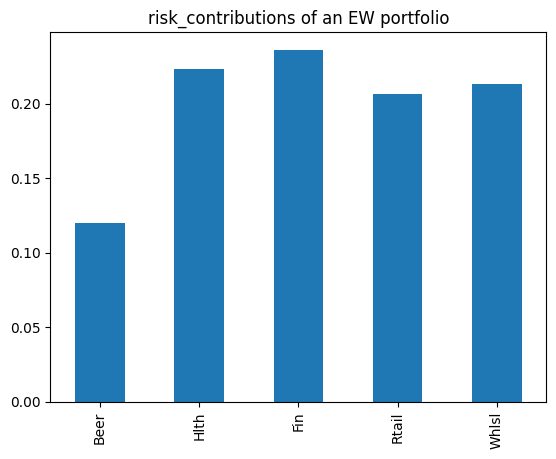

In [3]:
risk_contribution(erk.weight_ew(rets),cov).plot.bar(title='risk_contributions of an EW portfolio')

In [7]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """Returns the weights of the portfolio that gives you the weights such athat the contributions,
    to portfolio risk are as close as possible to the target_risk, given the covariance matrix"""
    n=cov.shape[0]
    init_guess=np.repeat(1/n,n)
    bounds=((0.0,1.0),)*n # an N-tuple of 2-tuples!
    #construct the constraints
    weights_sum_to_1={'type':'eq',
                      'fun':lambda weights: np.sum(weights)-1}
    def msd_risk(weights, target_risk,cov):
        """
        Returns the mean squared difference in risk contributions
        between weights and target_risk"""
        w_contribs=risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights=minimize(msd_risk, init_guess,
                     args=(target_risk,cov), method='SLSQP',
                     options={'disp':False},
                     constraints=(weights_sum_to_1,),
                     bounds=bounds)
    return weights.x
def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions of the constituents
    based on the given covariance matrix"""
    n=cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)



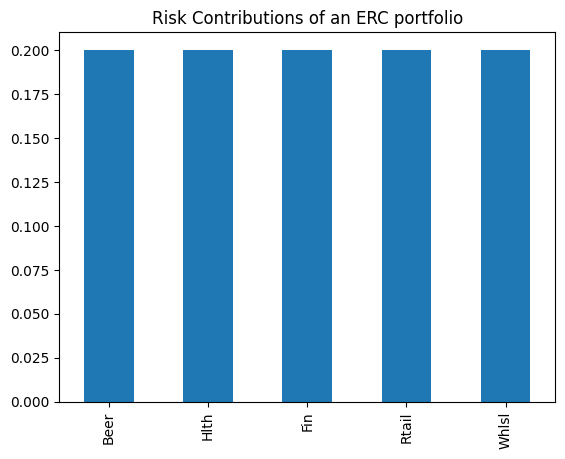

In [10]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [11]:
def weight_erc(r, cov_estimator=erk.sample_cov,**kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns"""
    est_cov = cov_estimator(r,**kwargs)
    return equal_risk_contributions(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117028,0.149425,-0.703895,5.444447,0.066769,0.096505,0.566698,-0.518418


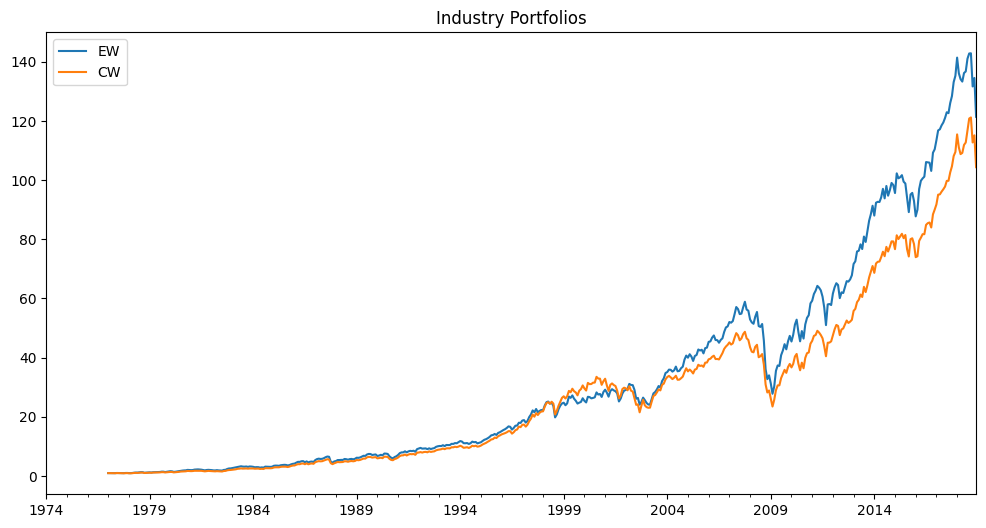

In [12]:
ewr=erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr=erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr=pd.DataFrame({"EW":ewr, "CW":cwr})
(1+btr).cumprod().plot(figsize=(12,6),title="Industry Portfolios")
erk.summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117028,0.149425,-0.703895,5.444447,0.066769,0.096505,0.566698,-0.518418
ERC-Sample,0.120185,0.149185,-0.872577,7.019237,0.066886,0.096357,0.588203,-0.502950


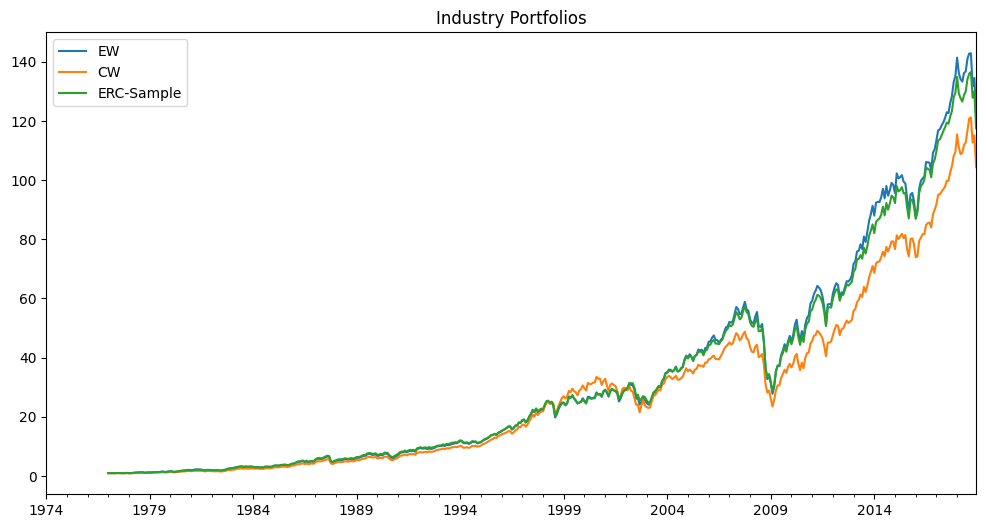

In [13]:
mv_erc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=erk.sample_cov)
btr = pd.DataFrame({"EW":ewr, "CW":cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6),title="Industry Portfolios")
erk.summary_stats(btr.dropna())